In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [19]:
!kaggle datasets download -d kazimkili/spinach-adulterated-pistachios

Dataset URL: https://www.kaggle.com/datasets/kazimkili/spinach-adulterated-pistachios
License(s): unknown
spinach-adulterated-pistachios.zip: Skipping, found more recently modified local copy (use --force to force download)


In [20]:
!unzip /content/spinach-adulterated-pistachios.zip -d dataset

Archive:  /content/spinach-adulterated-pistachios.zip
replace dataset/10% spinach adulterated pistachios/IMG_2209.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [21]:
import os
import shutil

# Define the path to the original dataset and the new dataset
original_dataset_directory = './dataset'
new_dataset_directory = './dataset_binary_classification'

# Create new dataset directory if it does not exist
if not os.path.exists(new_dataset_directory):
    os.makedirs(new_dataset_directory)

# Define the paths for the new class directories
spinach_adulterated_dir = os.path.join(new_dataset_directory, 'Spinach_Adulterated')
pure_pistachios_dir = os.path.join(new_dataset_directory, 'Pure_Pistachios')

# Create new class directories if they do not exist
if not os.path.exists(spinach_adulterated_dir):
    os.makedirs(spinach_adulterated_dir)
if not os.path.exists(pure_pistachios_dir):
    os.makedirs(pure_pistachios_dir)


# Adultared folder names
adulterated_folders = [folder for folder in os.listdir(original_dataset_directory) if 'adulterated' in folder.lower()]

for folder in adulterated_folders:
    folder_path = os.path.join(original_dataset_directory, folder)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                shutil.copy(file_path, spinach_adulterated_dir)

# Move pure pistachio images to the Pure_Pistachios folder
pure_pistachios_path = os.path.join(original_dataset_directory, 'Pure pistachios')
if os.path.exists(pure_pistachios_path):
    for filename in os.listdir(pure_pistachios_path):
        file_path = os.path.join(pure_pistachios_path, filename)
        if os.path.isfile(file_path):
            shutil.copy(file_path, pure_pistachios_dir)

print("Dataset restructuring complete successfully!")


Dataset restructuring complete successfully!


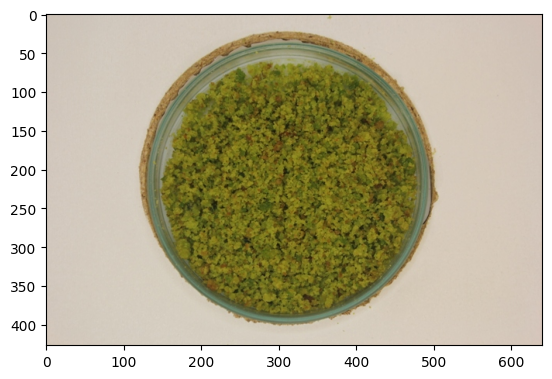

In [22]:
# Load image from dataset
from PIL import Image
image = Image.open('./dataset_binary_classification/Pure_Pistachios/IMG_2003.JPG')
plt.imshow(image)

In [23]:
import cv2

In [24]:
def crop_center_square(image, size):
    h, w = image.shape[:2]
    # Calculate coordinates for cropping
    top = (h - size) // 2
    bottom = top + size
    left = (w - size) // 2
    right = left + size
    # Crop the center square
    cropped = image[top:bottom, left:right]
    return cropped

In [25]:
from PIL import Image

def load_images(folder_path):
    images = []
    labels = []
    for label, folder_name in enumerate(['Pure_Pistachios', 'Spinach_Adulterated']):
        folder = os.path.join(folder_path, folder_name)
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            # convert the image to numpy array
            img = np.array(img)

            # Crop the center square of the image: 128x128
            img = crop_center_square(img, 128)

            images.append(img)
            labels.append(label)


    return np.array(images), np.array(labels)

In [26]:
from sklearn.model_selection import train_test_split


# Load dataset
dataset_folder = '/content/dataset_binary_classification'
X, y = load_images(dataset_folder)

# Split dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize images
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

# Filter out pure pistachios images for training autoencoder
pure_pistachios_indices = np.where(y_train == 0)[0]
X_pure_pistachios_train = X_train[pure_pistachios_indices]
y_pure_pistachios_train = y_train[pure_pistachios_indices]

In [27]:
X_pure_pistachios_train.shape

(160, 128, 128, 3)

In [28]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dense

# Define the autoencoder model architecture
input_img = Input(shape=(128, 128, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_absolute_error')  # Use binary cross-entropy loss for RGB images

# Print the summary of the model
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
#Its better to increase the epochs number 
autoencoder.fit(X_pure_pistachios_train, X_pure_pistachios_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(X_val, X_val))


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 773ms/step - loss: 0.1770 - val_loss: 0.0968
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0848 - val_loss: 0.0782
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0756 - val_loss: 0.0782
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0740 - val_loss: 0.0756
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0696 - val_loss: 0.0744
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0684 - val_loss: 0.0736
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0669 - val_loss: 0.0727
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0661 - val_loss: 0.0715
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0654 - val_loss: 0.0709
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0651 - val_loss: 0.0711
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0647 - val_loss: 0.0719
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0645 - val_

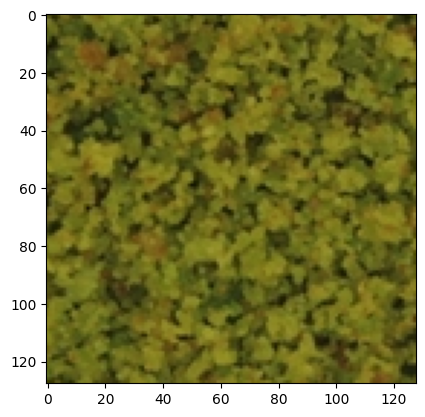

In [30]:
original=X_pure_pistachios_train[0].reshape(128, 128, 3)
plt.imshow(original)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
0.00351191


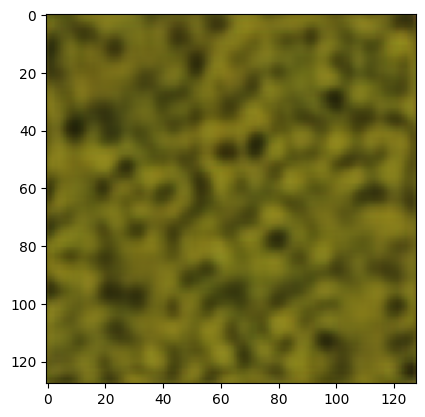

In [31]:
reconstructed = autoencoder.predict(X_pure_pistachios_train[0].reshape(1, 128, 128, 3)).reshape(128, 128, 3)
plt.imshow(reconstructed)
error = np.mean(np.square(original - reconstructed), axis=(1))
print(np.mean(error))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


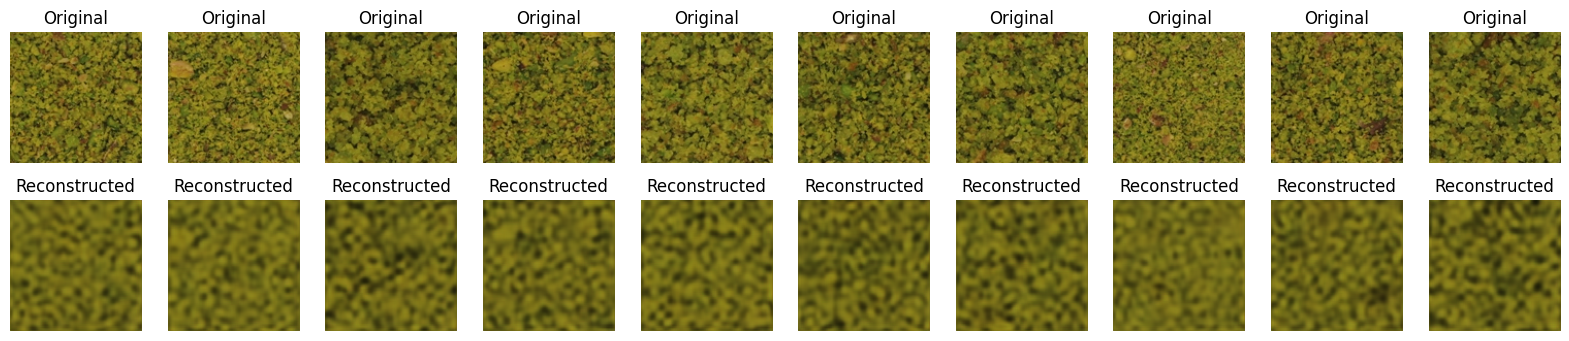

In [32]:
def display_images(original, decoded, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis('off')

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded[i])
        plt.title("Reconstructed")
        plt.axis('off')
    plt.show()

# Use the autoencoder to reconstruct the validation images
decoded_imgs = autoencoder.predict(X_val)

# Display original and reconstructed images
display_images(X_val, decoded_imgs)

In [33]:
non_pure_pistachios_indices = np.where(y_train == 1)[0]
X_non_pure_pistachios_train = X_train[non_pure_pistachios_indices]
X_non_pure_pistachios_train = X_non_pure_pistachios_train[::3]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step


(array([ 1.,  0.,  1.,  1.,  2.,  4.,  4.,  2.,  4.,  8.,  4., 15.,  7.,
         5.,  6.,  7.,  8.,  8.,  7.,  2.,  5.,  8.,  9.,  7.,  8.,  8.,
        11., 12., 11.,  5., 11., 13.,  5.,  7., 10.,  7.,  6.,  8.,  4.,
         6.,  5.,  1.,  3.,  3.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.]),
 array([0.00323059, 0.0032892 , 0.00334782, 0.00340644, 0.00346506,
        0.00352367, 0.00358229, 0.00364091, 0.00369952, 0.00375814,
        0.00381676, 0.00387537, 0.00393399, 0.00399261, 0.00405123,
        0.00410984, 0.00416846, 0.00422708, 0.00428569, 0.00434431,
        0.00440293, 0.00446154, 0.00452016, 0.00457878, 0.0046374 ,
        0.00469601, 0.00475463, 0.00481325, 0.00487186, 0.00493048,
        0.0049891 , 0.00504771, 0.00510633, 0.00516495, 0.00522357,
        0.00528218, 0.0053408 , 0.00539942, 0.00545803, 0.00551665,
        0.00557527, 0.00563388, 0.0056925 , 0.00575112, 

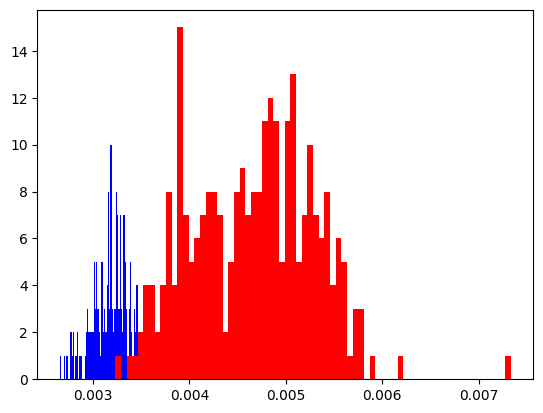

In [34]:
reconstructed = autoencoder.predict(X_pure_pistachios_train)
train_loss_pur = np.mean(np.square(X_pure_pistachios_train - reconstructed), axis=(1, 2, 3))
# print(mse_errors.shape)

reconstructed_non_pur = autoencoder.predict(X_non_pure_pistachios_train)
train_loss_non_pur = np.mean(np.square(X_non_pure_pistachios_train - reconstructed_non_pur), axis=(1, 2, 3))

# train_loss = np.mean(tf.keras.losses.mse(reconstructed, X_pure_pistachios_train))
# print(train_loss.shape)
plt.hist(train_loss_pur, bins=70, color='b')
plt.hist(train_loss_non_pur, bins=70, color='r')


In [35]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Anomaly detection using error threshold
def anomaly_detection(model, images, threshold):
    reconstructed = autoencoder.predict(images)
    loss = np.mean(np.square(images - reconstructed), axis=(1, 2, 3))
    print(loss)
    anomalies = loss < threshold
    return anomalies

    # anomalies = []
    # for image in images :
    #   reconstructed = model.predict(image)
    #   # error = np.mean(np.mean(np.square(image - reconstructed), axis=(1)))
    #   error = np.mean(np.square(image - reconstructed), axis=(1, 2, 3))
    #   print(error)
    #   anomalies.append(error > threshold)
    # return anomalies

if np.isnan(y_val).any():
    raise ValueError("Labels contain NaN values.")


# pure_pistachios_indices_val = np.where(y_val == 0)[0]
# X_pure_pistachios_val = X_val[pure_pistachios_indices_val]
# y_pure_pistachios_val = y_val[pure_pistachios_indices_val]

# # Obtain reconstruction errors for pure validation data
# pure_val_reconstructions = autoencoder.predict(X_pure_pistachios_train)
# pure_val_errors = np.mean(np.square(X_pure_pistachios_train - pure_val_reconstructions), axis=(1))


val_reconstructions = autoencoder.predict(X_val)
val_errors = np.mean(np.square(X_val - val_reconstructions), axis=(1))

# Calculate the threshold
# error_threshold = np.mean(pure_val_errors) + 1.5 * np.std(pure_val_errors)
error_threshold = 0.0036
print(error_threshold)


# Perform anomaly detection on the full validation set
anomalies = anomaly_detection(autoencoder, X_val, error_threshold)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
0.0036
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
[0.00500758 0.00548066 0.00325605 0.0046479  0.00403649 0.00441138
 0.003583   0.0050084  0.00469768 0.00322137 0.00461663 0.00528639
 0.00389947 0.00480473 0.00430076 0.00412213 0.00390191 0.00454791
 0.00386591 0.0047834  0.00455957 0.00498751 0.00540688 0.00458601
 0.00365556 0.00471332 0.00558851 0.00527003 0.0053142  0.00604674
 0.00505822 0.00308208 0.00398644 0.00474993 0.00495133 0.00310594
 0.00541724 0.00373004 0.00336713 0.00515564 0.00306078 0.00494218
 0.00435971 0.00315604 0.00413649 0.00497288 0.00519259 0.00384267
 0.00444734 0.00459548 0.00519463 0.00507749 0.00303702 0.00441744
 0.00537374 0.00549112 0.00380434 0.00372436 0.00512723 0.00309595
 0.00443312 0.00510907 0.00317885 0.00387205 0.00470151 0.00479917
 0.00469639 0.00367089 0.00483558 0.00459208 0.00381776 0.00368521
 0.00286139 0.00518698 0.00307134 0.00327241 0.00470016 0.00294345
 0.00389758 0.00492889 0.00430183 0.00352782 0

Accuracy: 0.9836065573770492


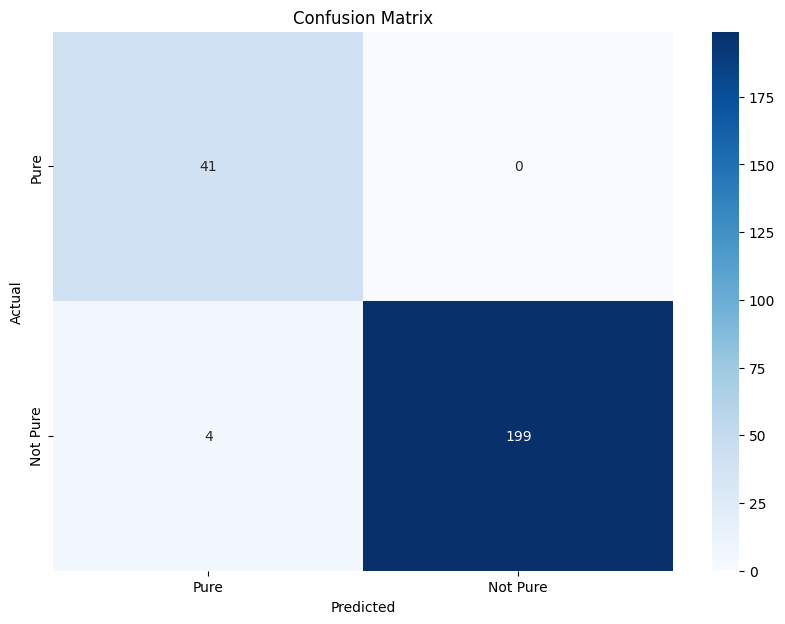

In [36]:
# Invert anomalies to get predictions
predictions = np.logical_not(anomalies)

predictions = predictions.astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_val, predictions)
print("Accuracy:", accuracy)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_val, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Pure', 'Not Pure'], yticklabels=['Pure', 'Not Pure'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()